In [ ]:
!python -c "import torch; print(torch.__version__)"
!pip install --no-index torch-scatter -f https://pytorch-geometric.com/whl/torch-1.8.0+cu101.html
!pip install --no-index torch-sparse -f https://pytorch-geometric.com/whl/torch-1.8.0+cu101.html
!pip install --no-index torch-cluster -f https://pytorch-geometric.com/whl/torch-1.8.0+cu101.html
!pip install --no-index torch-spline-conv -f https://pytorch-geometric.com/whl/torch-1.8.0+cu101.html
!pip install torch-geometric
!pip install gpytorch

In [2]:
#@title imports
import networkx as nx
import torch
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
from torch_geometric.datasets import Planetoid
from torch_geometric.datasets import TUDataset
from torch_geometric.data import DataLoader
from torch_geometric.utils import to_dense_adj
from torch_geometric.utils import add_self_loops
from torch_geometric.utils.convert import to_networkx
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch.nn import Linear
from gpytorch.kernels import LinearKernel

# Load Data

In [125]:
#@title Select Dataset
name = "AIDS" #@param ["ENZYMES","aspirin","AIDS"]

dataset = TUDataset('./data',name,use_node_attr=True)
loader = DataLoader(dataset, batch_size=32, shuffle=True)

42


[]

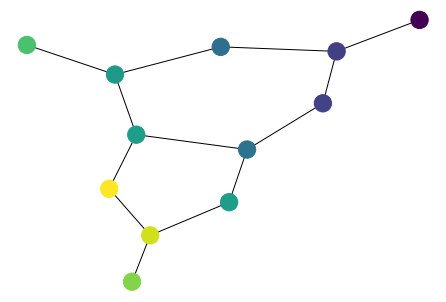

In [126]:
#@title Visualize
idx =  25#@param {type:"number"}
x_shape = dataset[idx].x.size()[1]
print(x_shape)
g = to_networkx(dataset[idx],to_undirected=True)
color = torch.tensor(range(x_shape),dtype=torch.float)
c = torch.matmul(dataset[idx].x,color)
nx.draw(g,node_color=c)
plt.plot()

In [127]:
mean = torch.mean(dataset.data.x,dim=0)
var = torch.var(dataset.data.x,dim=0)
dataset.data.x = (dataset.data.x-mean)/var

# Node Level Autoencoder

In [128]:
class BaseEcoder(torch.nn.Module):
    def __init__(self, hidden_channels):
        super(BaseEcoder, self).__init__()
        self.conv1 = GCNConv(dataset.num_features, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, 16)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = F.dropout(x, p=0.3, training=self.training)
        x = self.conv2(x, edge_index)
        return x

class BaseDecoder(torch.nn.Module):
    def __init__(self,variacnce):
        super(BaseDecoder, self).__init__()
        self.lkernelop = LinearKernel()
        self.lkernelop.variance = variacnce

    def forward(self, embedding, batch):
        graphs = batch.to_data_list()
        num_nodes = [graph.num_nodes for graph in graphs]
        dense_adj = to_dense_adj(batch.edge_index,batch.batch)
        graphwise_node_embedding = torch.split(embedding,num_nodes)
        pred_probs = [] 
        true_probs = []
        for idx,node_embedding in enumerate(graphwise_node_embedding):
            indices = torch.triu_indices(num_nodes[idx],
                                         num_nodes[idx], 1)
            kernel = self.lkernelop(node_embedding).evaluate()
            pred_probs.append(torch.sigmoid(kernel[indices[0],indices[1]])) 
            true_probs.append(dense_adj[idx][indices[0],indices[1]])
        return torch.cat(pred_probs), torch.cat(true_probs)

class BaseAutoencoder(torch.nn.Module):
    def __init__(self, hidden_channels):
        super(BaseAutoencoder, self).__init__()
        self.encoder = BaseEcoder(hidden_channels)
        self.decoder = BaseDecoder(1)

    def forward(self,batch):
        latent_space = self.encoder(batch.x,batch.edge_index)
        return self.decoder(latent_space,batch)
   
node_level_gae = BaseAutoencoder(18)

In [ ]:
# training loop
num_epochs = 200
optimizer = torch.optim.Adam(node_level_gae.parameters(), lr=1e-4)
epoch_loss=[]
node_level_gae.train()
for epoch in range(num_epochs):
    running_loss=[]
    for batch in loader:
        optimizer.zero_grad()
        pred_probs,true_probs = node_level_gae(batch)
        loss = F.binary_cross_entropy(pred_probs, true_probs)
        running_loss.append(loss.detach())
        loss.backward()
        optimizer.step()
    epoch_loss.append(np.mean(running_loss))
    print(f'\repoch[{epoch}]-loss[{epoch_loss[-1]}]')

<BarContainer object of 66 artists>

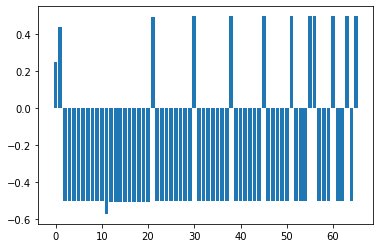

In [133]:
single_loader = DataLoader(dataset, batch_size=1, shuffle=True)
temp = next(iter(single_loader))
pred_probs,true_probs = node_level_gae(temp)
graphsize = len(pred_probs)
plt.bar(range(graphsize),(true_probs-pred_probs).detach())

The optimal strategy for the model is to map all nodes to the center (Zero) in the latent space hence $\sigma(0)=0.5$. But we expect the KL term in the variational loss to improve for that.